In [59]:
#import libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

- Will use the Fake News <a href='https://www.kaggle.com/c/fake-news/overview'>Kaggle competition</a> dataset for this project
- The objective of the project is to create a classifier that is able to idetify a fake article

# Data 

In [2]:
dataset = pd.read_csv('fake_news.csv')
print(dataset.shape)

(20800, 5)


In [3]:
dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
dataset[dataset['label'] ==1]['title'].to_list()[:5]

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It',
 'Why the Truth Might Get You Fired',
 '15 Civilians Killed In Single US Airstrike Have Been Identified',
 'Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery',
 'Life: Life Of Luxury: Elton John’s 6 Favorite Shark Pictures To Stare At During Long, Transcontinental Flights']

In [5]:
dataset[dataset['label'] ==0]['title'].to_list()[:5]

['FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart',
 'Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart',
 'Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times',
 'Excerpts From a Draft Script for Donald Trump’s Q&ampA With a Black Church’s Pastor - The New York Times',
 'A Back-Channel Plan for Ukraine and Russia, Courtesy of Trump Associates - The New York Times']

In [6]:
dataset['author'].nunique()

4201

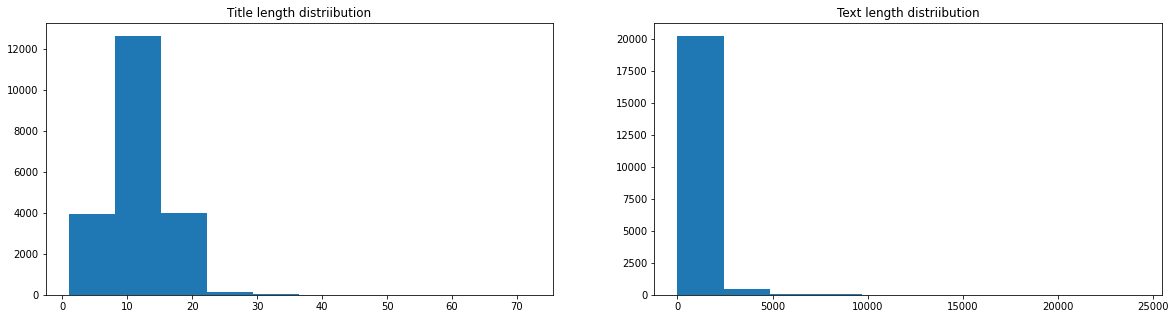

In [7]:
dataset['title_len'] = dataset['title'].apply(lambda x : len(str(x).split(' ')))
dataset['text_len'] = dataset['text'].apply(lambda x : len(str(x).split(' ')))

fig, axes = plt.subplots(nrows= 1, ncols= 2, figsize = (20,5))
axes = axes.flatten()

axes[0].hist(dataset['title_len'])
axes[0].set_title('Title length distriibution')
axes[1].hist(dataset['text_len'])
axes[1].set_title('Text length distriibution')
plt.show()

In [8]:
dataset['title_len'].describe()

count    20800.000000
mean        12.126298
std          4.443486
min          1.000000
25%          9.000000
50%         12.000000
75%         15.000000
max         72.000000
Name: title_len, dtype: float64

In [9]:
dataset['text_len'].describe()

count    20800.000000
mean       773.202163
std        881.468450
min          1.000000
25%        273.000000
50%        565.000000
75%       1070.000000
max      24234.000000
Name: text_len, dtype: float64

- We have Title, Author & content of the article 
- In this project, we will be using ngram approach to predict whether it is fake news or not
- We will be using only the Title of the article

In [10]:
news_dataset = dataset[['title', 'label']]
news_dataset['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [30]:
news_dataset.dropna(inplace= True)

<ipython-input-30-73f540b88159>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset.dropna(inplace= True)


# Data Preprocessing Pipeline

In [37]:
#remove punctuation
import string
def remove_punctuation_func(text):
    '''
    Remove punctuations from the text
    '''
#     print(text)
    text= "".join([i for i in text if str(i) not in string.punctuation])
    return text

#tokenize text
import re
def tokenization(text):
    return text.split(' ')

#remove stopwords from tokenized text
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords_func(tokens):
    output= [i for i in tokens if str(i) not in stopwords]
    return output

#lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer_func(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text


In [44]:
text_preprocess_json = {
    'remove_punctuation' : True,
    'remove_stopwords' : True,
    'lemmatizer' : True
    
}

In [45]:
def text_preprocess_pipeline(df, col, **config) :
    
    '''
    text preprocess pipeline
    
    '''
    df['cleaned_text'] = df[col]
    
    if remove_punctuation :
        df['cleaned_text'] = df['cleaned_text'].apply(lambda x : remove_punctuation_func(x))
        
    if remove_stopwords :
        df['cleaned_text'] = df['cleaned_text'].apply(lambda x : tokenization(x))
        df['cleaned_text'] = df['cleaned_text'].apply(lambda x : remove_stopwords_func(x))
        
    if lemmatizer :
        df['cleaned_text'] = df['cleaned_text'].apply(lambda x : lemmatizer_func(x))
        
        
    return df
    

In [47]:
news_dataset = text_preprocess_pipeline(news_dataset, col = 'title', **text_preprocess_json)
news_dataset['cleaned_text'] = news_dataset['cleaned_text'].apply(lambda x : ' '.join(x))
news_dataset.head()

,title,label,cleaned_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide We Didn’t Even See Comey’s Lett...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0,FLYNN Hillary Clinton Big Woman Campus Breitbart
2,Why the Truth Might Get You Fired,1,Why Truth Might Get You Fired
3,15 Civilians Killed In Single US Airstrike Hav...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,1,Iranian woman jailed fictional unpublished sto...


# Feature Extraction & Modeling

In [54]:
#separating the data and label
X = news_dataset['cleaned_text'].values
y = news_dataset['label'].values

In [55]:
#using TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)
print(X.shape)

(20242, 24063)


In [56]:
#train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=2)
print(X_train.shape, X_test.shape)

(16193, 24063) (4049, 24063)


In [61]:
#train model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Evaluation 

In [63]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = metrics.accuracy_score(X_train_prediction, y_train)

print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9441734082628296


In [66]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = metrics.accuracy_score(X_test_prediction, y_test)

print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9264015806371944


In [68]:
#save the model
import pickle 
pickle.dump(model, open('fake_news_detector.pkl', 'wb'))

In [70]:
#save the tfidf transformer
pickle.dump(vectorizer, open('fake_news_vectorizer.pkl', 'wb'))

# Making a Prediction 

In [86]:
#load model
trained_model = pickle.load(open('fake_news_detector.pkl', 'rb'))

#load vectorizer
trained_vectorizer = pickle.load(open('fake_news_vectorizer.pkl', 'rb'))

def fake_news_prediction(sentence) :
    
    vector = trained_vectorizer.transform(sentence)
    prediction = trained_model.predict(vector)
    
    if (prediction[0]=='1'):
        print('Alert! This is a FAKE NEWS!')
    else:
        print('This might not be fake news')
    

In [87]:
fake_news_prediction(['They are giving 100 new free cars'])

This might not be fake news
